In [1]:
%pylab inline
#%pylab notebook
import GPS_helper as GPS
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

# Kalman Filter Variables

<img src="figs/Kalman_variables.png" width="50%">

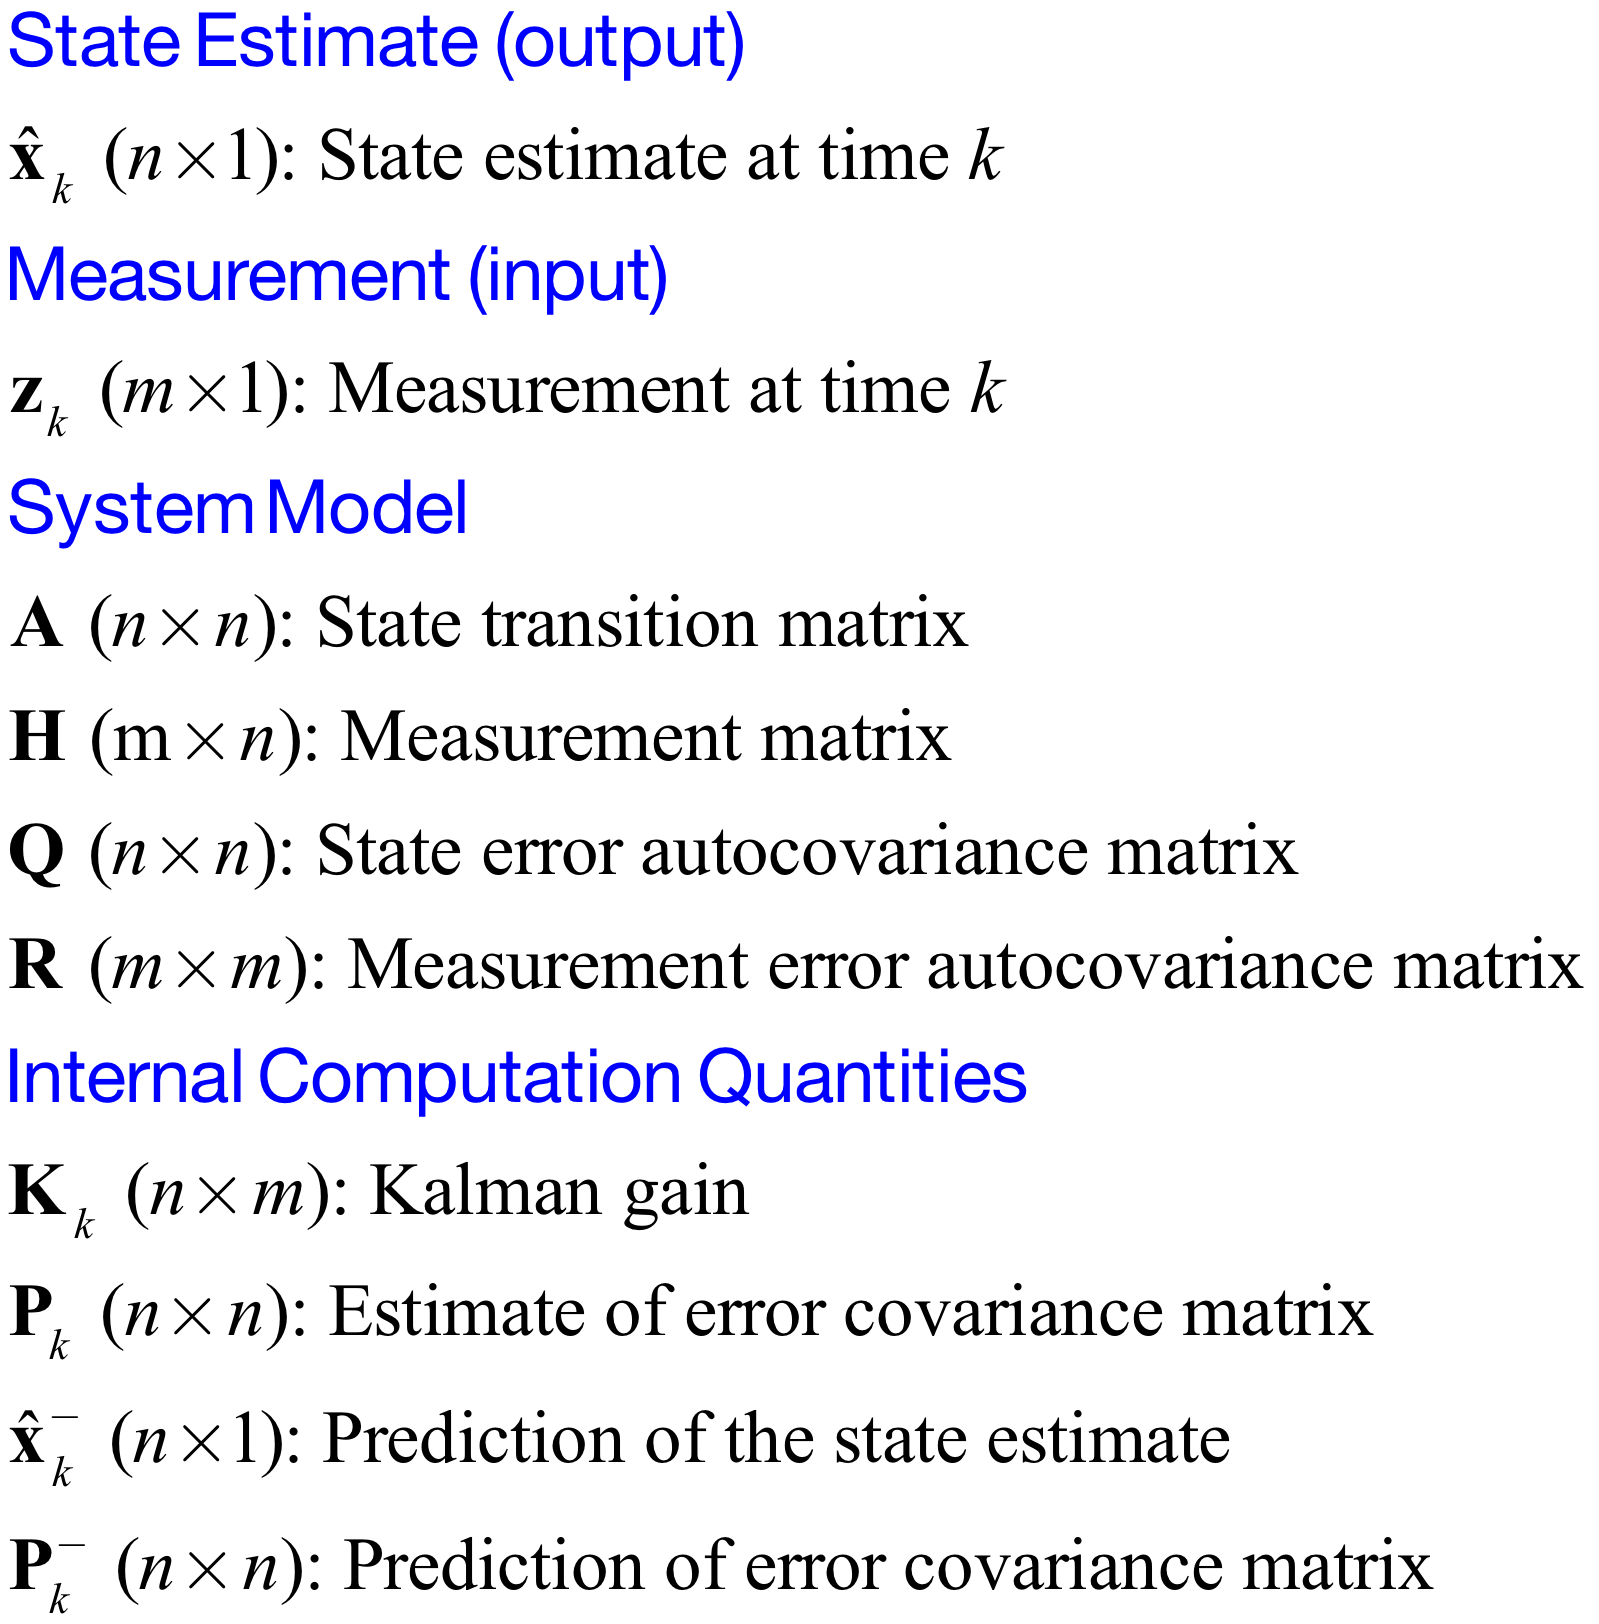

In [7]:
Image('figs/Kalman_variables.png',width='60%')

# General Extended Kalman Filter (EKF) Block Diagram

<img src="figs/EKF_Filter.png" width="60%">

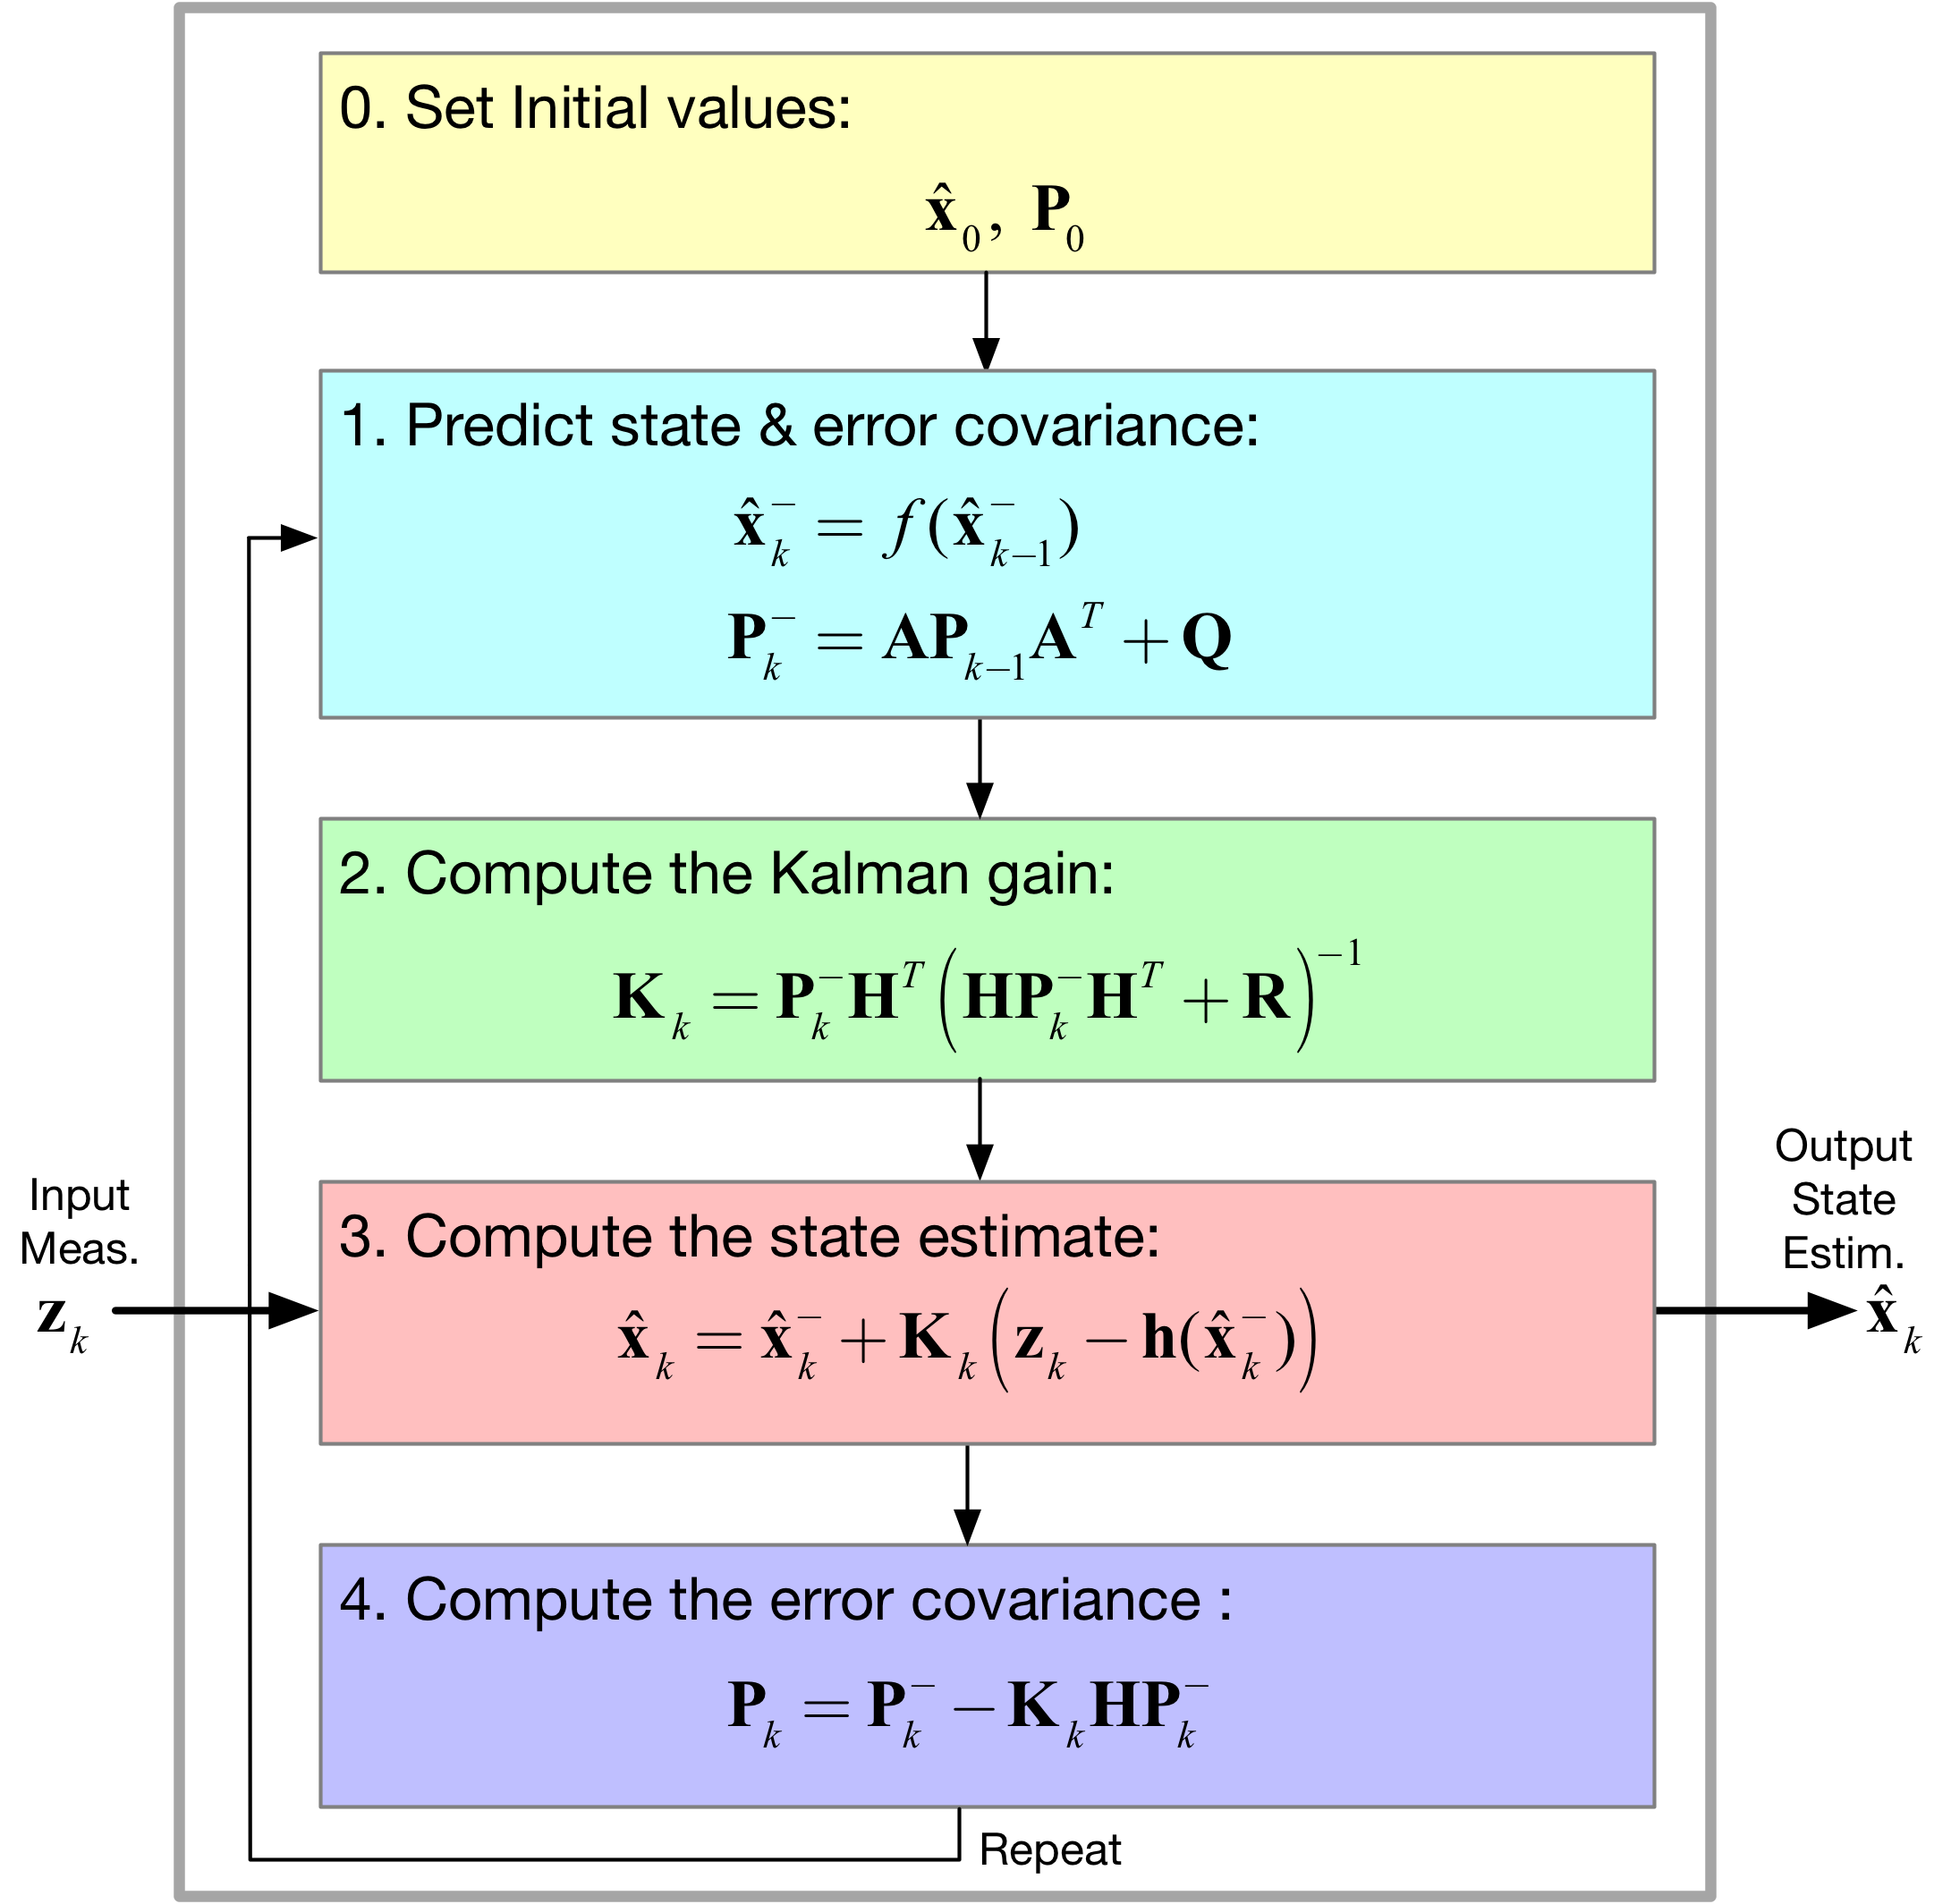

In [5]:
Image('figs/EKF_Filter.png',width='70%')

# Application to GPS using Simulated User and Satellite Trajectories 
To make a realistic and flexible simulation environment we use a User trajectory generator that converts East-north-up (ENU) coordinates into earth-centric earth fixed coordinates (ECEF) (see details of ECEF in a later figure). A conversion from [ENU to ECEF](http://www.navipedia.net/index.php/Transformations_between_ECEF_and_ENU_coordinates) is also required.

The GPS satellites are in a medium earth orbit and hence have significant motion during most *User* tracking error experiments. To provide a realistic trajectory model we use the Python package [SGP4](https://pypi.python.org/pypi/sgp4/) along with two-line elements (TLEs) sets for the GPS satellites to provides the needed ECEF coordinates versus time. Since SGP4 delivers satellite ephemeris in earth centered interial coordinates, a conversion from ECI to ECEF is also required. The TLEs are obtain from [celestrak](https://www.celestrak.com/NORAD/elements/gps-ops.txt).

<img src="figs/Earth_Centered_Inertial_Coordinate_System.png" width="40%">

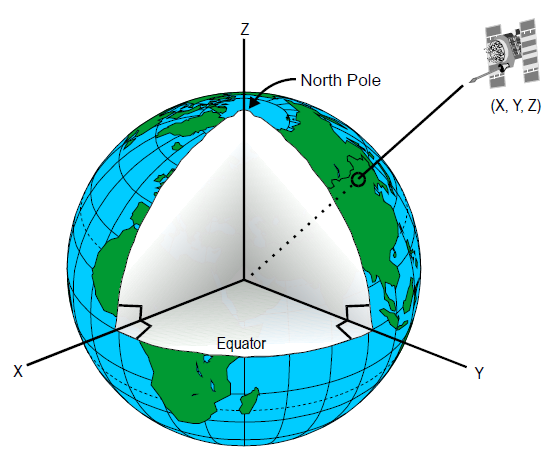

In [15]:
Image('figs/Earth_Centered_Inertial_Coordinate_System.png',width='50%')

### A Simple Example
* Generate a user trajectory
* Pair the trajectory with a collection of appropriately chosen GPS satellites keyed to the C/A code PRN number, e.g., PRN 21, etc.

In [3]:
# Line segment User Trajectory
rl1 = [('e',.2),('n',.4),('e',-0.1),('n',-0.2),('e',-0.1),('n',-0.1)]
rl1

[('e', 0.2), ('n', 0.4), ('e', -0.1), ('n', -0.2), ('e', -0.1), ('n', -0.1)]

In [4]:
# Create a GPS data source
GPS_ds1 = GPS.GPS_data_source('GPS_tle_1_10_2018.txt',
                              Rx_sv_list = \
                              ('PRN 32','PRN 21','PRN 10','PRN 18'),
                              ref_lla=(38.8454167, -104.7215556, 1903.0),
                              Ts = 1)

In [5]:
# Populate User and SV trajectory matrices
USER_vel = 5 # mph
USER_Pos_enu, USER_Pos_ecf, SV_Pos, SV_Vel = \
              GPS_ds1.user_traj_gen(route_list=rl1,
                                    Vmph=USER_vel,
                                    yr2=18, # the 2k year, so 2018 is 18
                                    mon=1,
                                    day=15,
                                    hr=8+7,
                                    minute=45) # Jan 18, 2018, 8:45 AM

In [6]:
# Check a user position
USER_Pos_ecf[0,:]

array([-1264404.16643545, -4812254.11855508,  3980159.53945133])

#### Generate a 3D View of the Trajectories

Duration: 13.20 min


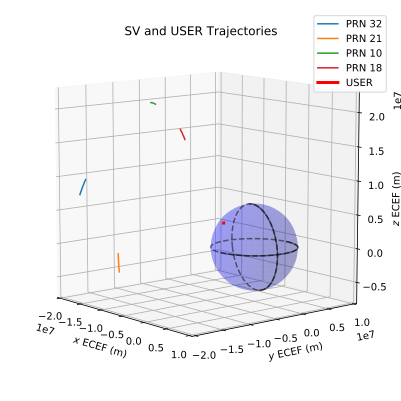

In [7]:
GPS.SV_User_Traj_3D(GPS_ds1,SV_Pos,USER_Pos_ecf,ele=20,azim=-40)
savefig('GPS_ds1.png',dpi=300)

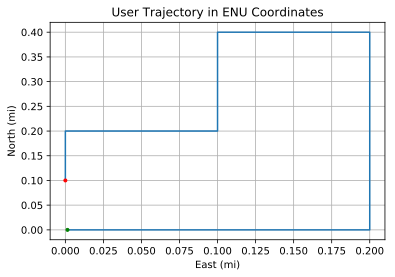

In [8]:
plot(USER_Pos_enu[:,0],USER_Pos_enu[:,1])
plot(USER_Pos_enu[0,0],USER_Pos_enu[0,1],'g.')
plot(USER_Pos_enu[-1,0],USER_Pos_enu[-1,1],'r.')
title(r'User Trajectory in ENU Coordinates')
xlabel(r'East (mi)')
ylabel(r'North (mi)')
grid();

## Develop a GPS EKF
The constant velocity process model of [2] is adopted for this project. The step is defining the eight element state vector $\mathbf{x}$:

<img src="figs/Process_Model1.png" width="70%">

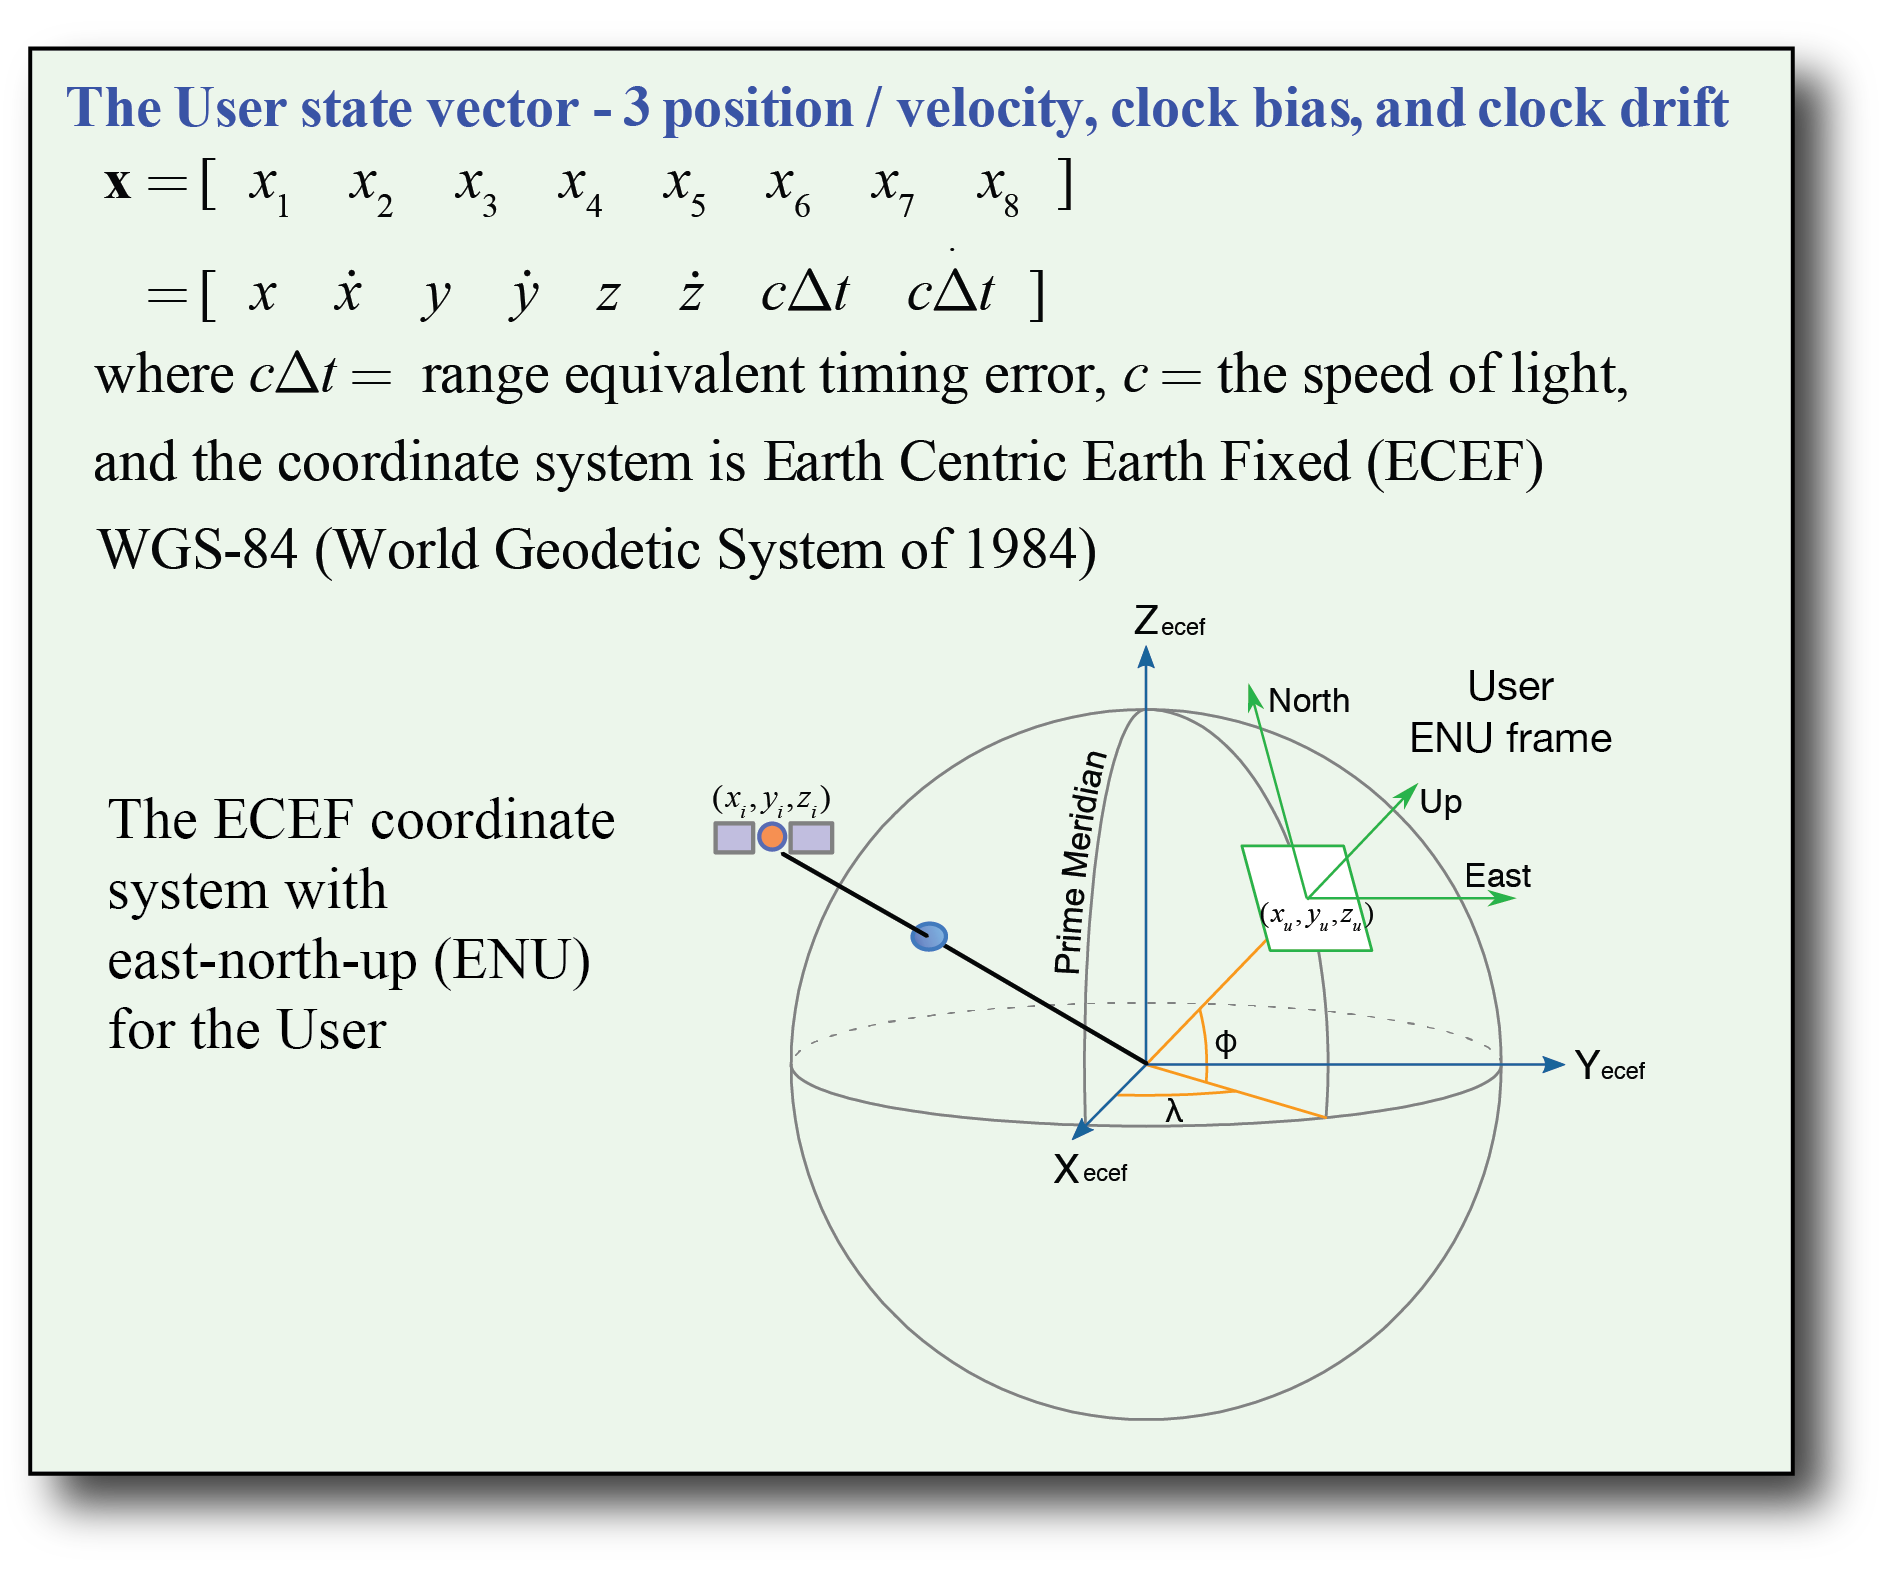

In [30]:
Image('figs/Process_Model1.png',width='80%')

The EKF allows nonlinearities in both the process model and the measurement model. For the case of GPS the state transition model is linear, thus the first calculation of **Step 1**, *predicted state update expression*, is the same as that found in the standard linear Kalman filter. What is needed is a state transition matrix:

<img src="figs/Process_Model2.png" width="70%">

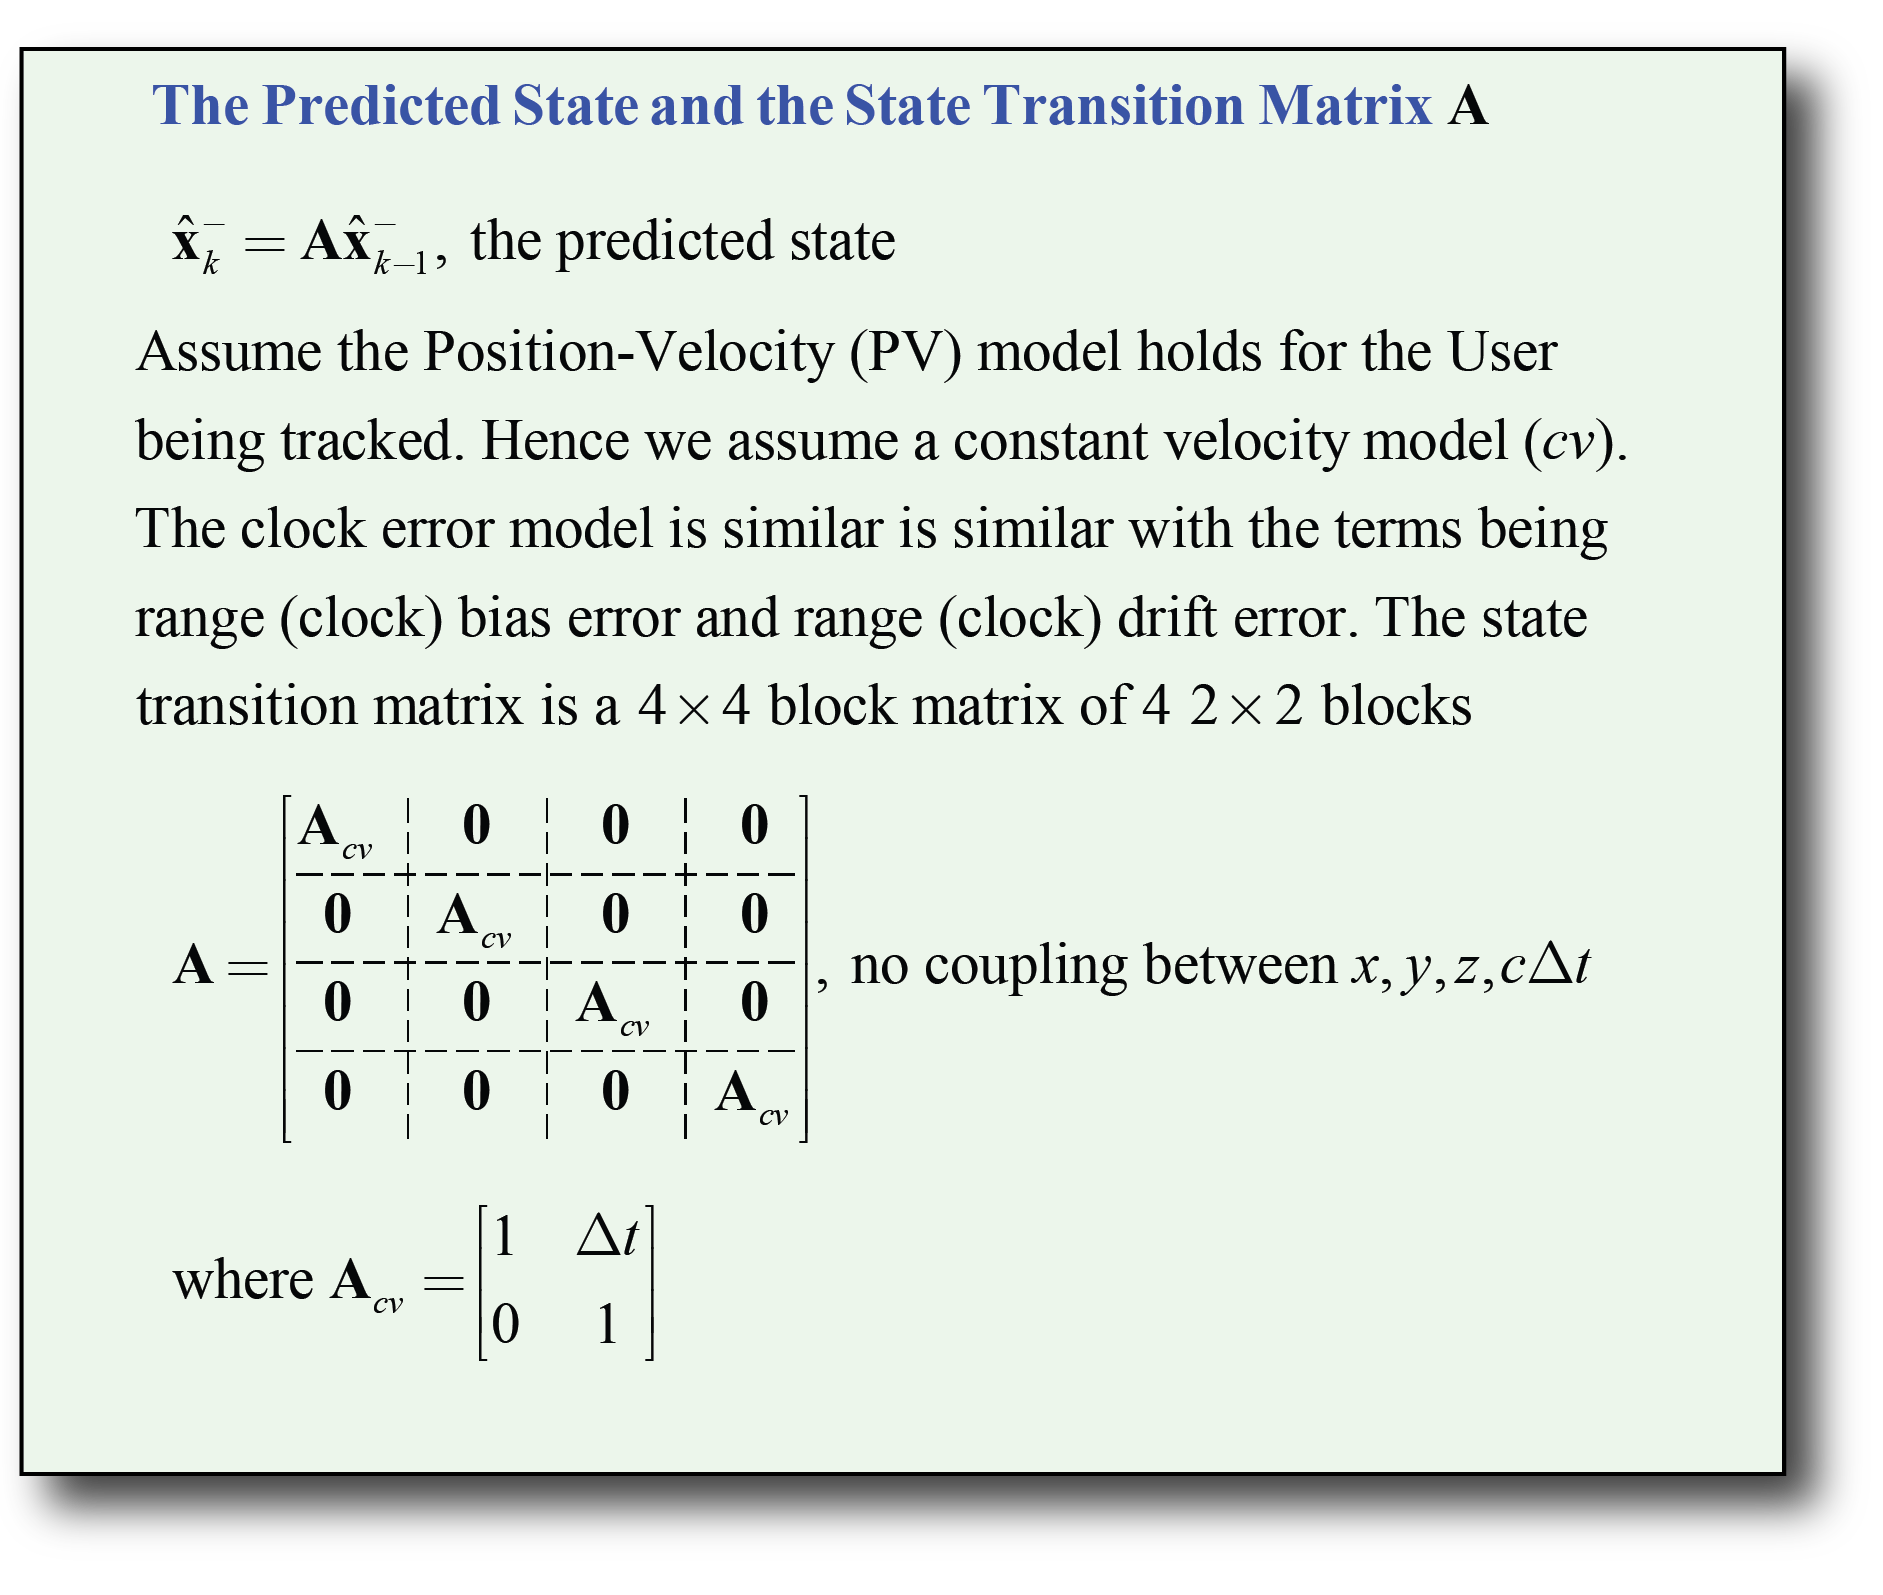

In [19]:
Image('figs/Process_Model2.png',width='80%')

The second part of **Step 1** is forming the predicted error covariance matrix from the previous error covariance matrix. This calculation on the process model covariance matrix, $\mathbf{Q}$:

<img src="figs/Process_Model3.png" width="70%">

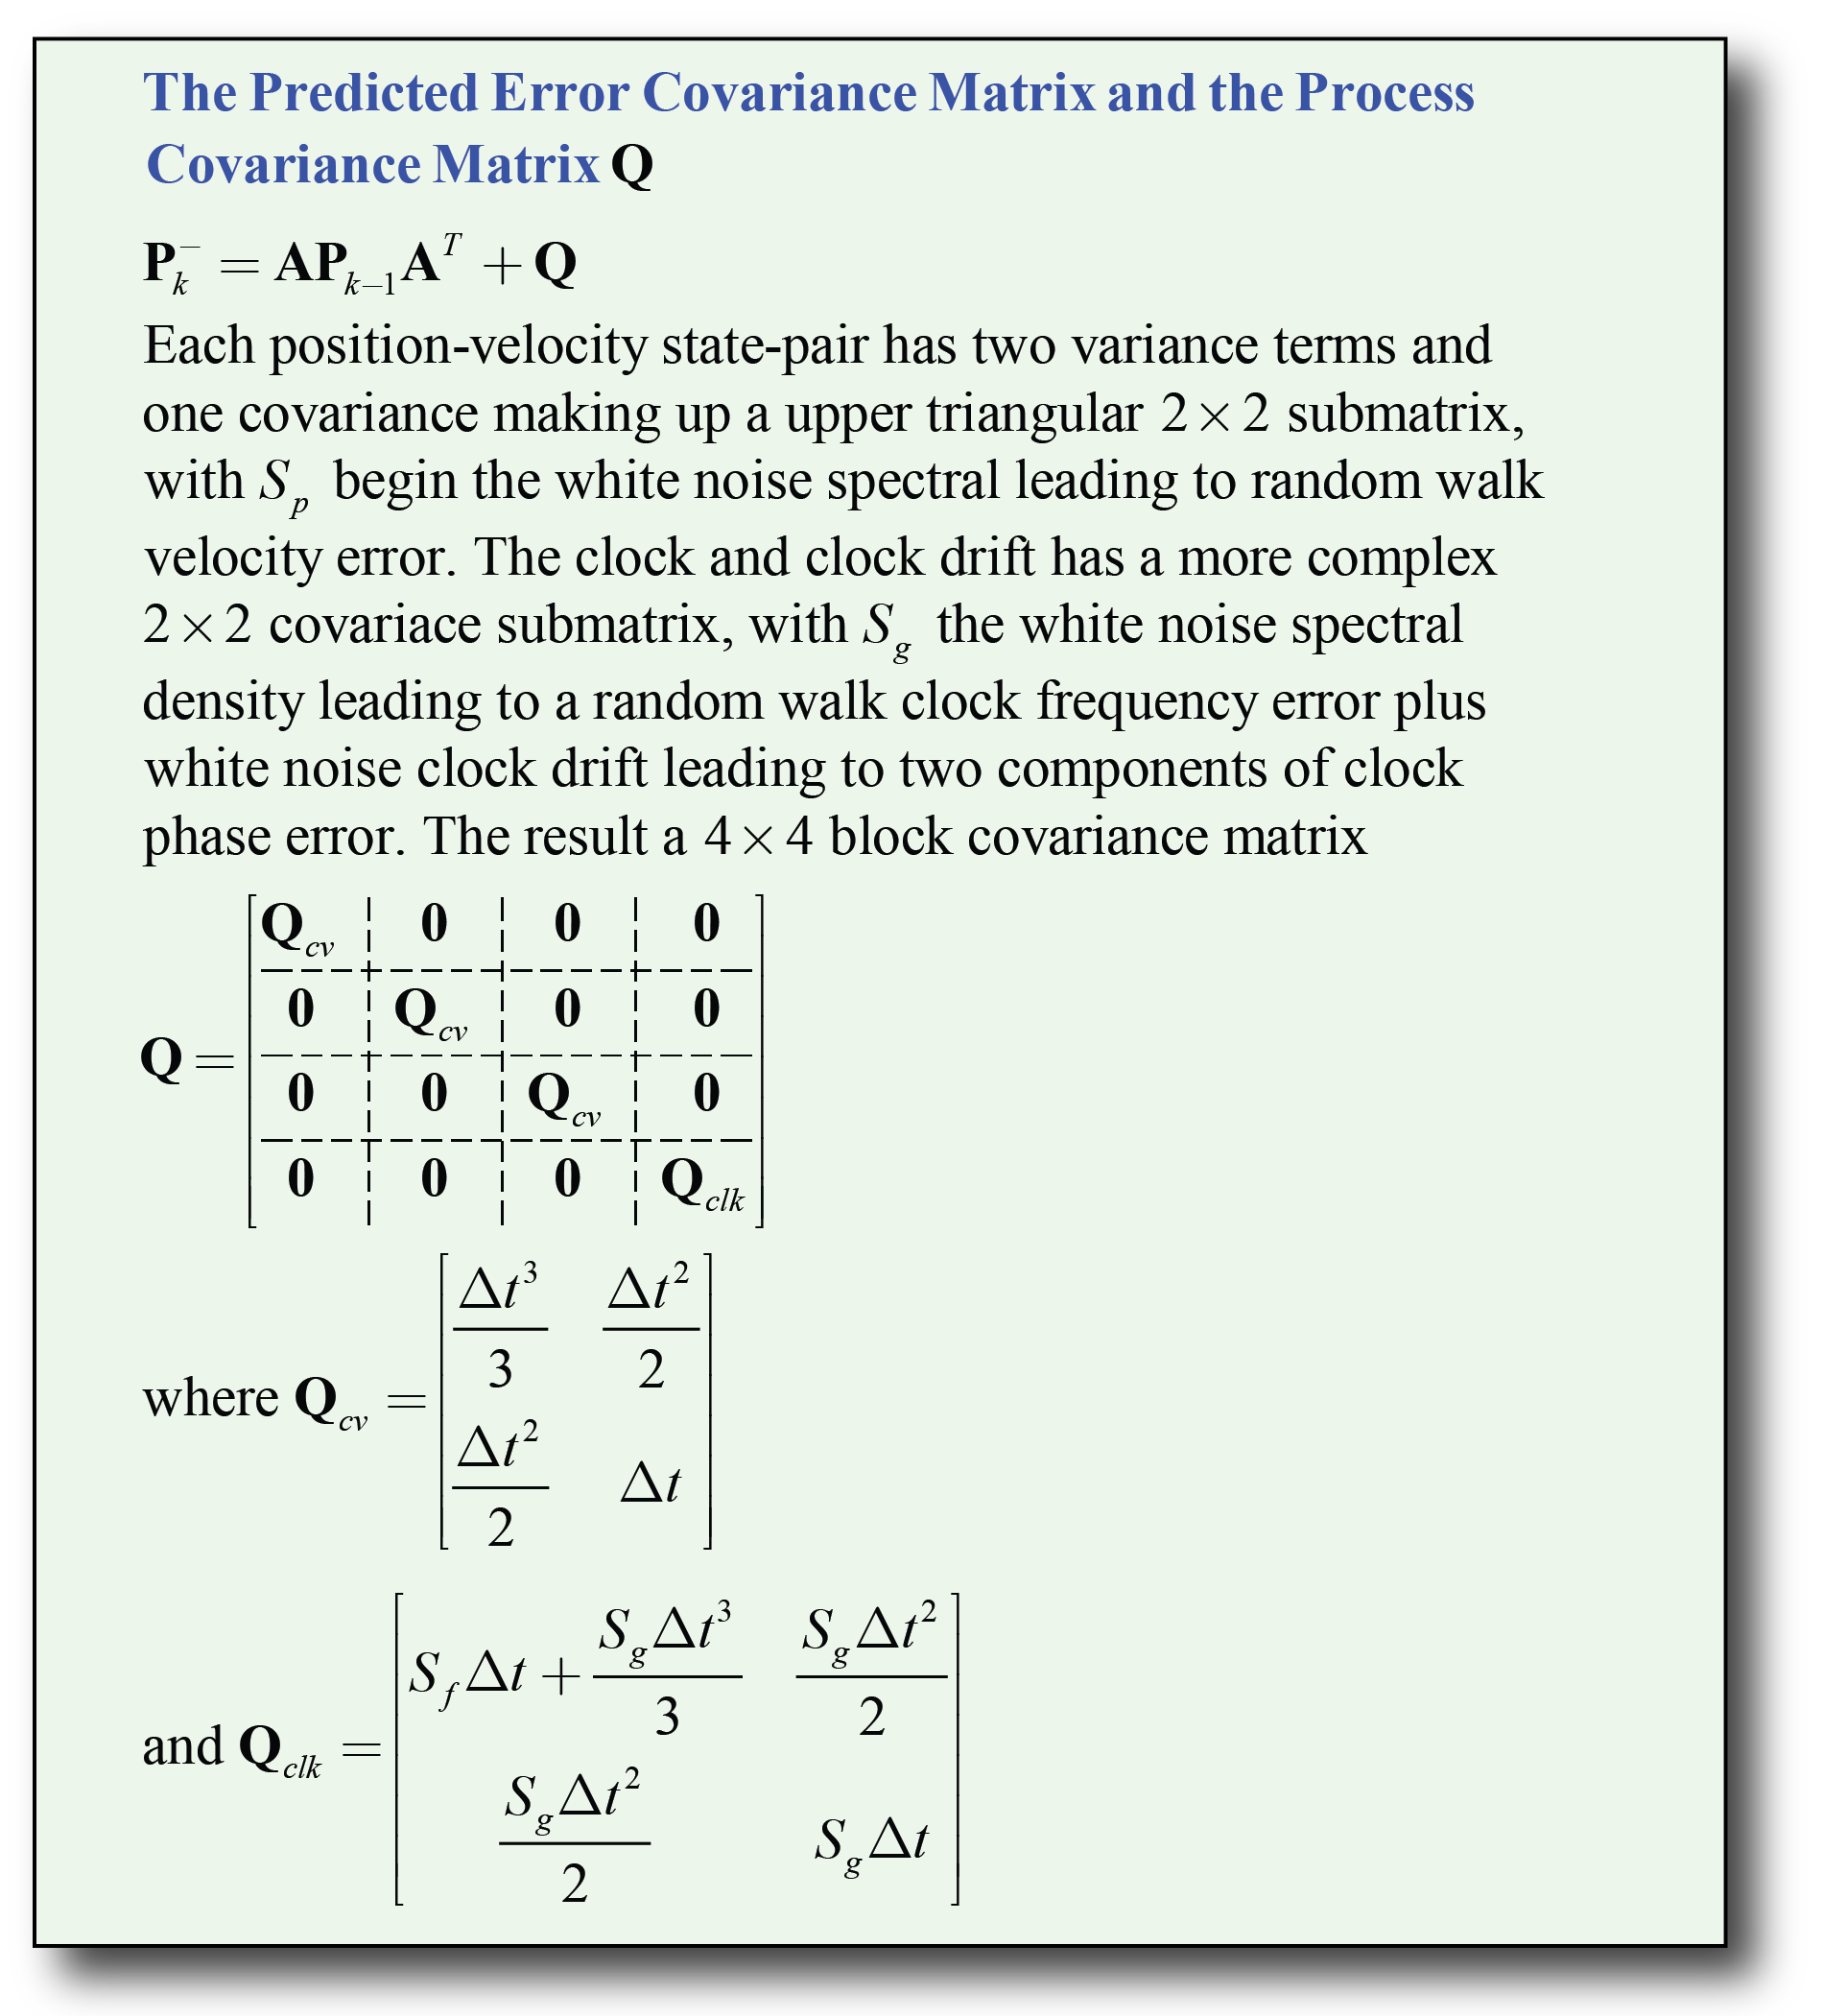

In [20]:
Image('figs/Process_Model3.png',width='80%')

## Simulated Pseudo Range from the User and Satellite Trajectories
The EKF will use satellite epheneris data from the 50 bps message sent from each satellite. The pseudo range to each satellite is obtained from the cross correlation of the received C/A code for a given satellite the locally generated C/A for the satellite. Clock errors factored into the spedurange measurement.

<img src="figs/Measurement_Model1.png" width="60%">

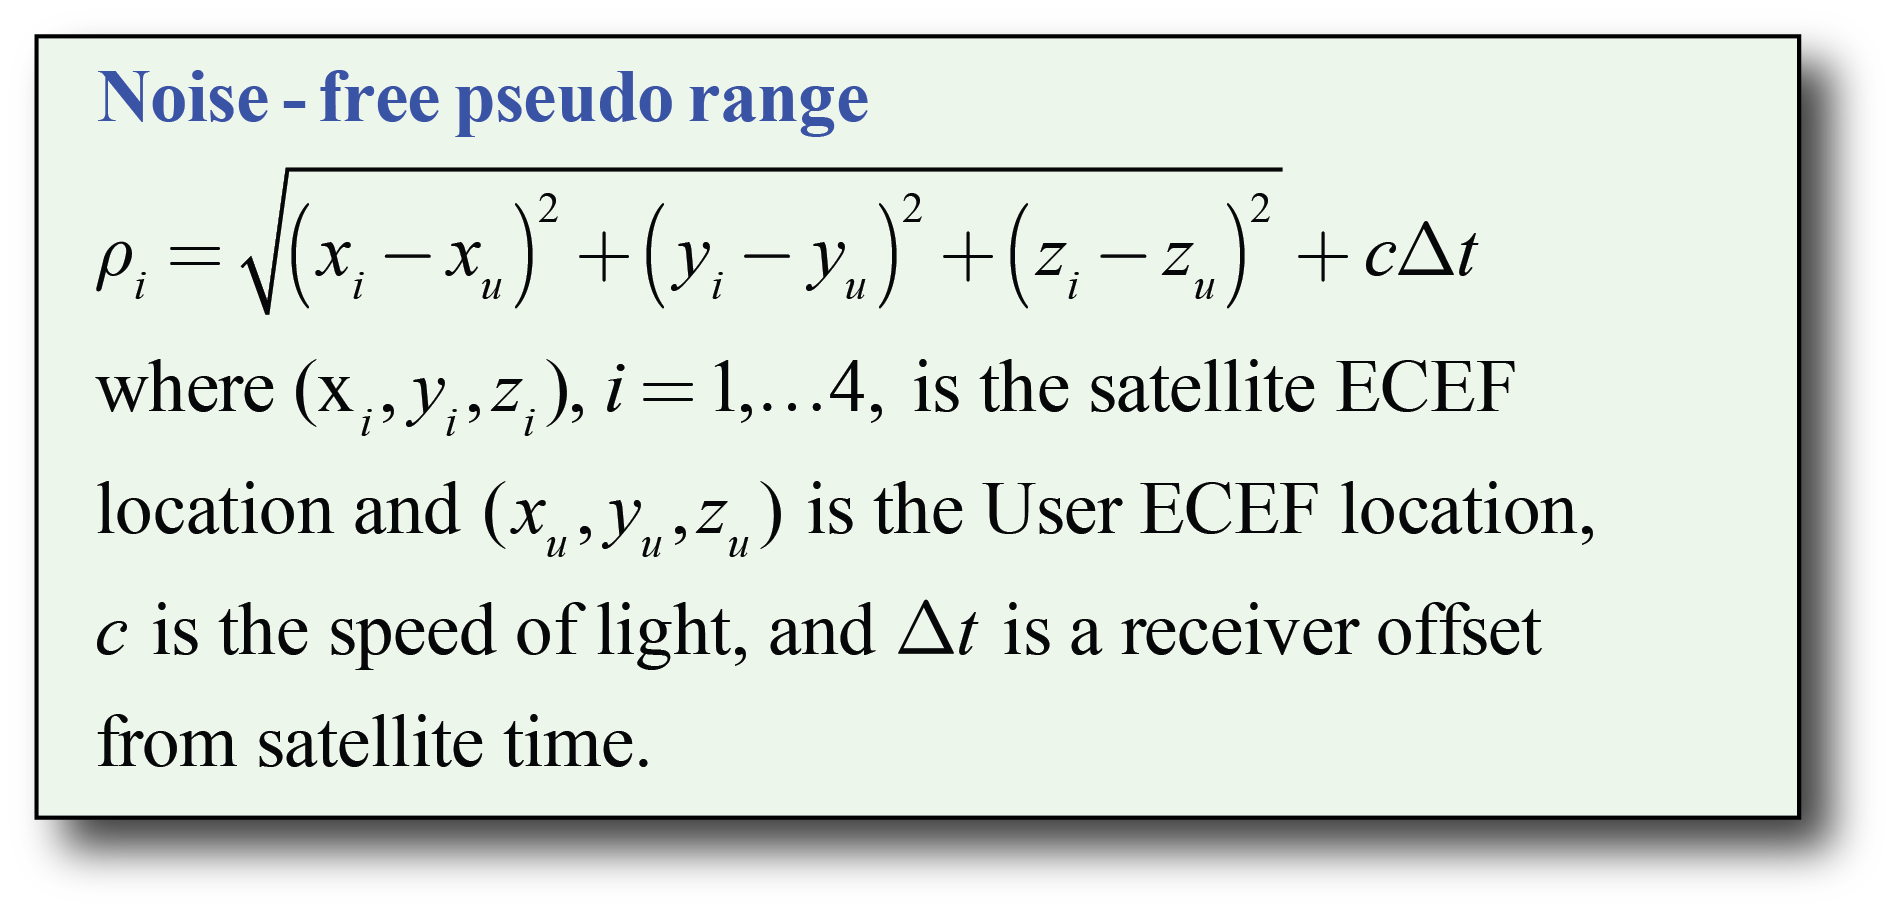

In [28]:
Image('figs/Measurement_Model1.png',width='70%')

A class is created for obtaining the simulated pseudorange from the User and satellite trajectories. The associated update time is defined in the generation of the trajectories.

In [14]:
class GetPseudoRange(object):
    """
    A class for generating simulated Pseudo range measurements from
    simulated SV ECEF and simulated User ECEF trajectories. The number of 
    measurements is 4, but more or less measurements can be specified 
    assuming the number of SVs configured matches.
    
    Mark Wickert January 2018
    """
    
    
    def __init__ (self, PR_std = 0, CDt = 0, N_SV = 4):
        """
        Initialize the object
        """
        self.PR_std = PR_std
        self.CDt = CDt
        self.N_SV = N_SV
        self.USER_PR = zeros((N_SV,1))
        
           
    def measurement(self, USER_Pos_ecef, SV_Pos_ecef):
        """
        Take a measurement by passing in position values at time
        index i, i.e., USER_Pos_ecf[i,:] & SV_Pos[:,:,i]
        """
        # Compute the pseudo range to each SV
        for k in range(self.N_SV):
            self.USER_PR[k,0] = norm(USER_Pos_ecef - SV_Pos_ecef[k])
            # Add bias and measurement noise
            self.USER_PR[k,0] +=  self.CDt + self.PR_std*random.randn(1)[0]
        return

## The EKF Class for Estimating Position from the Pseudorange Measurements
Beyond the linear Kalman filter, the EKF needs to implement a linearization of the measurement equations. In particular we need $\mathbf{H}$, which we get by forming the Jacobian of the measurement model.

<img src="figs/Measurement_Model2.png" width="60%">

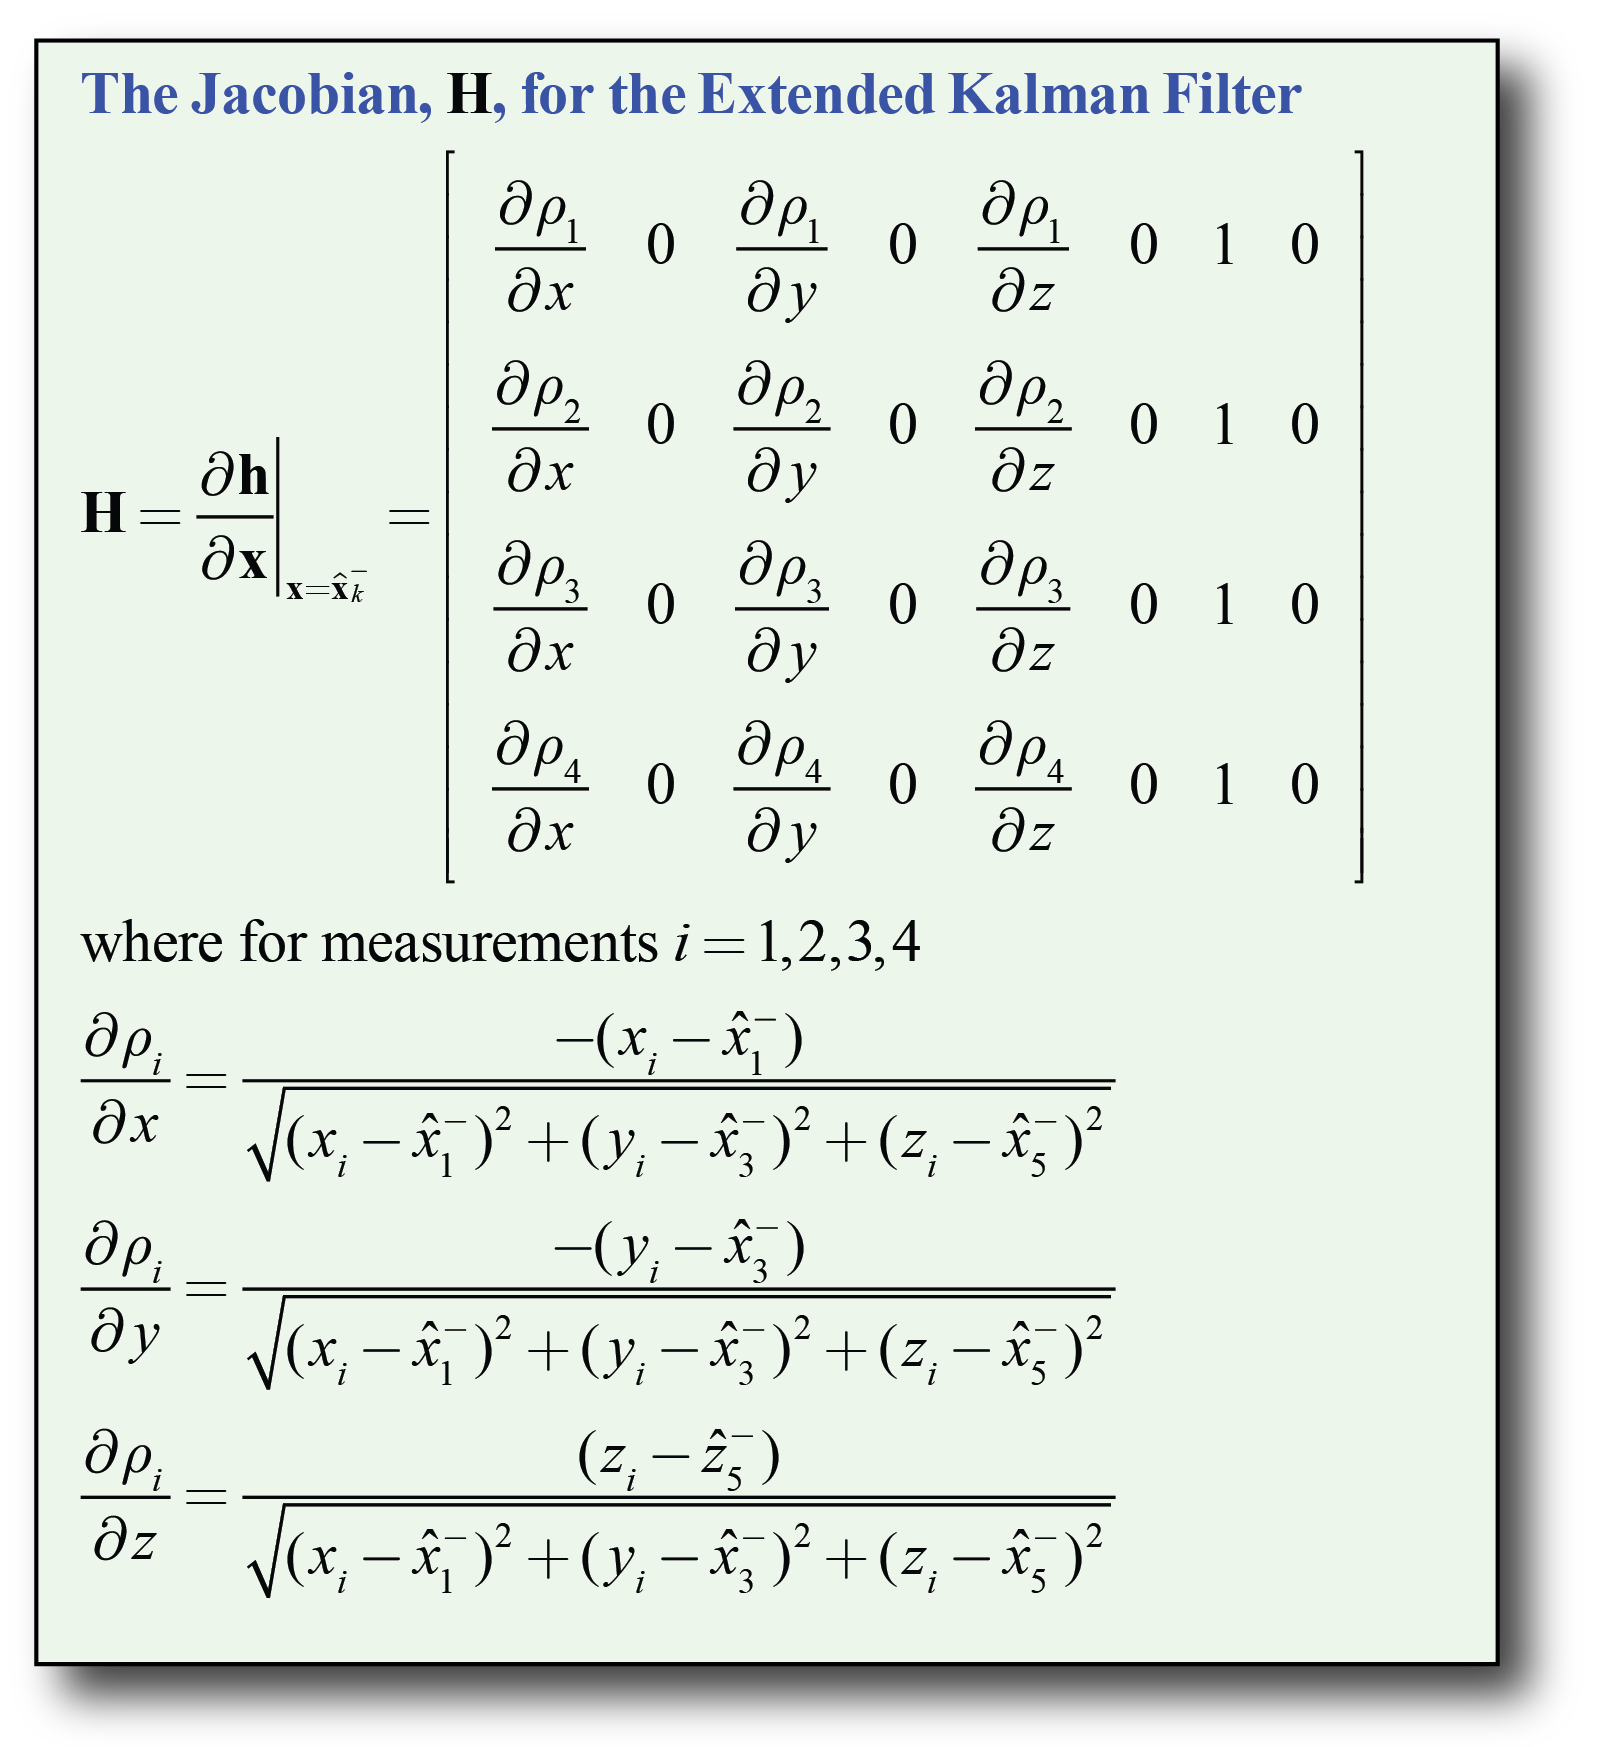

In [29]:
Image('figs/Measurement_Model2.png',width='70%')

In [13]:
class GPS_EKF(object):
    """
    GPS Extended Kalman Filter User Tracking using SGP4-based SV tracks in ECEF 
    and ENU user tracks converted to ECEF so that simulated pseudo range 
    measurements can be made. The overall formulation is based on the book by
    Robert Brown & Patrick Hwang, "Introduction to Random Signals and Applied 
    Kalman Filtering with MATLAB Exercises", 4th edition, 2012.
    
    Python 3.x is assumed so the operator @ can be used for matrix multiply
    
    Mark Wickert January 2018
    """

    
    def __init__ (self, USER_xyz_init, dt = 1, sigma_xyz = 5, 
                  Sf = 36, Sg = 0.01, Rhoerror = 36, N_SV = 4):
        """
        Initialize the object
        
        The state vector x is composed of eight components:
        
        [x_pos, x_vel, y_pos, y_vel, z_pos, z_vel, clk_bias, clk_bias_rate].T
        
        Futhermore a constant velocity model is chosen for the process model
        """
        self.dt = dt
        self.N_SV = N_SV
        # Create a block diagonal state transition matrix
        A_cv = array([[1, dt],[0, 1]]) # 2x2 block
        A_cvr = hstack((A_cv,zeros((2,N_SV+2)))) #block with zeros appended
        self.A = vstack((A_cvr,roll(A_cvr,2),roll(A_cvr,4),roll(A_cvr,6)))
        # Process model covariance Q [Brown & Hwang] is subblocks Qxyz and Qb 
        Qxyz = sigma_xyz**2 * array([[dt**3/3, dt**2/2],[dt**2/2, dt]])
        Qb = array([[Sf*dt+Sg*dt**3/3, Sg*dt**2/2], [Sg*dt**2/2, Sg*dt]])
        # Create a block diagonal matrix to hold 2x2 blocks
        Qxyzr = hstack((Qxyz,zeros((2,6))))
        Qbr = hstack((Qb,zeros((2,6))))
        self.Q = vstack((Qxyzr,roll(Qxyzr,2),roll(Qxyzr,4),roll(Qbr,6)))

        # Measurement model covariance matrix R 
        # Rhoerror = variance of measurement error(pseudorange error)
        self.R = Rhoerror*eye(N_SV) 
        # Error covariance matrix initialize 
        self.P = 10*eye(8)
        # Initialize state vector
        self.x = zeros((8,1))
        self.x[0:6:2,0] = USER_xyz_init
        self.x[1:7:2,0] = [0, 0, 0]  # Initial velocity
        self.x[6,0] = 0 #3.575e6     # Initial c*clock bias in m
        self.x[7,0] = 0 #4.549e1     # Initial c*clock drift in m/s
                   
        
    def update(self, z, SV_Pos):
        """
        Update the Kalman filter state by inputting a new set of 
        pseudorange measurements.
        Return the state array as a tuple.
        Update all other Kalman filter quantities
        Input SV ephemeris at one time step, e.g., SV_Pos[:,:,i]
        """
        # H = Matrix of partials dh/dx
        H = self.Hjacob(self.x, SV_Pos)
        
        xp = self.A @ self.x
        Pp = self.A @ self.P @ self.A.T + self.Q
        
        self.K = Pp @ H.T @ inv(H @ Pp @ H.T + self.R)
        
        # zp = h(xp), the predicted pseudorange
        zp = self.hx(xp, SV_Pos)
        
        self.x = xp + self.K @ (z - zp)
        self.P = Pp - self.K @ H @ Pp
        # Return the x,y,z position (also held in the state vector attribute)
        return self.x[0,0], self.x[2,0], self.x[4,0]
    
    
    def Hjacob(self,xp,SV_Pos):
        """
        Jacobian used to linearize the measurement matrix H
        given the state vector and the known positions of each SV.
        Here we assume 4 SV are used, but more measurements may be
        added.
        
        Parameters
        ----------
        xp : Predicted state vector
        SV_Pos : 4x3xN matrix of SV ECEF coordinates (4 => self.S_SV)
        
        Returns
        -------
        H : The linearized 4x8 measurement matrix H for each time update
        
        Mark Wickert January 2018
        """
        H = zeros((self.N_SV,8))
        for i in range(self.N_SV):
            den = norm(xp[:6:2].flatten() - SV_Pos[i,:])
            H[i,0:6:2] = (xp[0:6:2].flatten() - SV_Pos[i,:])/den
            H[i,6] = 1.0   
        return H
    
    
    def hx(self,xp,SV_Pos):
        """
        The predicted pseudorange zp computed from xp and the SV
        ephemeris stored in SV_Pos array, but in practice the receiver
        has SV ephemeris info from the 50 bps message
        
        Parameters
        ----------
        xp : Predicted state vector
        SV_Pos : 4x3xN matrix of SV ECEF coordinates (4 => self.S_SV)
        
        Returns
        -------
        zp : The predicted via h(xp)
        
        Mark Wickert January 2018        
        """
        zp = zeros((self.N_SV,1))
        for i in range(self.N_SV):
            den = norm(xp[:6:2].flatten() - SV_Pos[i,:])
            zp[i,0] = den + xp[6]   
        return zp      

## Case #1

### Run Simulation for Case #1

In [12]:
Nsamples = SV_Pos.shape[2]
print('Sim Seconds = %d' % Nsamples)
dt = 1
# Save user position history
Pos_KF = zeros((Nsamples,3))
# Save history of error covariance matrix diagonal 
P_diag = zeros((Nsamples,8))

Pseudo_ranges1 = GetPseudoRange(PR_std=0.1,CDt=0,N_SV=4)
GPS_EKF1 = GPS_EKF(USER_xyz_init=USER_Pos_ecf[0,:] + 5*randn(3),
                   dt=1,
                   sigma_xyz=5,
                   Sf=36,
                   Sg=0.01,
                   Rhoerror=36,
                   N_SV=4)
for k in range(Nsamples):
    Pseudo_ranges1.measurement(USER_Pos_ecf[k,:],SV_Pos[:,:,k])
    GPS_EKF1.update(Pseudo_ranges1.USER_PR,SV_Pos[:,:,k])
    Pos_KF[k,:] = GPS_EKF1.x[0:6:2,0]
    P_diag[k,:] = GPS_EKF1.P.diagonal()

Sim Seconds = 792


### The ECEF User Track
The error is small as the noise and other uncertainties, at present are small.

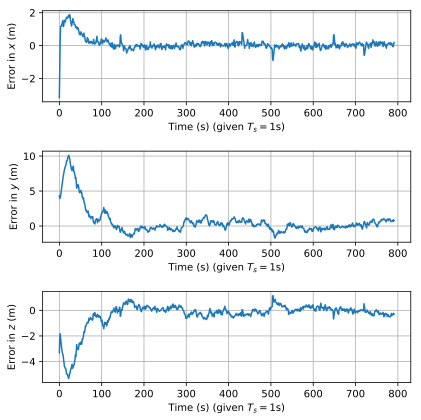

In [13]:
figure(figsize=(6,6))
subplot(311)
Pos_err_KF_ecf = Pos_KF - USER_Pos_ecf
plot(Pos_err_KF_ecf[:,0])
ylabel(r'Error in $x$ (m)')
xlabel(r'Time (s) (given $T_s = 1$s)')
#ylim([-12,12])
grid()
subplot(312)
plot(Pos_err_KF_ecf[:,1])
ylabel(r'Error in $y$ (m)')
xlabel(r'Time (s) (given $T_s = 1$s)')
#ylim([-12,12])
grid()
subplot(313)
plot(Pos_err_KF_ecf[:,2])
ylabel(r'Error in $z$ (m)')
xlabel(r'Time (s) (given $T_s = 1$s)')
#ylim([-12,12])
grid()
tight_layout()

### Selected Error Covariance Results for the Simulation Run
The error covariance matrix, $\mathbf{P}$, is $8\times 8$, with the diagonal entries beingthe variances of each of the states.

Convergence looks reasonable as we see an intial error transient and then a gradual reduction in the covariance.

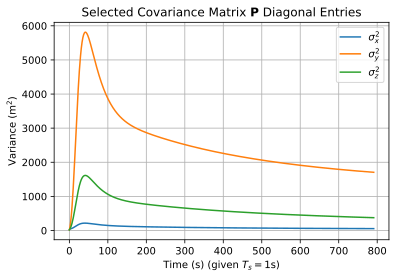

In [14]:
plot(P_diag[:,0])
plot(P_diag[:,2])
plot(P_diag[:,4])
title(r'Selected Covariance Matrix $\mathbf{P}$ Diagonal Entries')
ylabel(r'Variance (m$^2$)')
xlabel(r'Time (s) (given $T_s = 1$s)')
legend((r'$\sigma_x^2$',r'$\sigma_y^2$',r'$\sigma_z^2$'),loc='best')
grid();

* Consider the $6\times 6$ submatrix of $\mathbf{P}$ corresponding to the x, y, and z, position and velocity states, at the final time sample of the simulation run.

In [15]:
print(np.array_str(GPS_EKF1.P[:6,:6], precision=2))
#print np.array_str(x, precision=2, suppress_small=True)

[[ 5.55e+01  2.32e+01  1.43e+02  4.12e+00 -6.38e+01 -1.27e+00]
 [ 2.32e+01  3.46e+01  3.92e+00  6.13e-01 -1.24e+00  1.41e-01]
 [ 1.43e+02  3.92e+00  1.71e+03  6.97e+01 -7.57e+02 -2.11e+01]
 [ 4.12e+00  6.13e-01  6.97e+01  4.12e+01 -2.18e+01 -3.27e+00]
 [-6.38e+01 -1.24e+00 -7.57e+02 -2.18e+01  3.76e+02  2.80e+01]
 [-1.27e+00  1.41e-01 -2.11e+01 -3.27e+00  2.80e+01  3.26e+01]]


In [16]:
GPS_EKF1.P.diagonal()

array([5.54745383e+01, 3.46397865e+01, 1.70625839e+03, 4.11822186e+01,
       3.75796604e+02, 3.26168031e+01, 1.36063623e+03, 8.29052050e-01])

### Convert the ECEF User Trajectory Back to ENU Local Coordinates

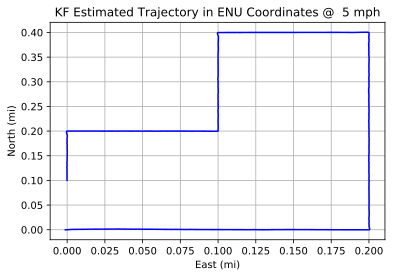

In [18]:
Npts = Pos_KF.shape[0]
Pos_KF_enu = zeros((Npts,3))
for k in range(Npts):
    Pos_KF_enu[k,:] = GPS.ecef2enu(Pos_KF[k,:],
                                   GPS_ds1.ref_ecef,
                                   GPS_ds1.ref_lla[0],
                                   GPS_ds1.ref_lla[1])
plot(Pos_KF_enu[:,0]/1609.344,Pos_KF_enu[:,1]/1609.344,'b')
title(r'KF Estimated Trajectory in ENU \
Coordinates @ %2.0f mph' % (USER_vel,))
xlabel(r'East (mi)')
ylabel(r'North (mi)')
grid();

## Case #2

In [19]:
# Line segment User Trajectory
rl1 = [('e',.2),('n',.4),('e',-0.1),('n',-0.2),('e',-0.1),('n',-0.1)]
rl1

[('e', 0.2), ('n', 0.4), ('e', -0.1), ('n', -0.2), ('e', -0.1), ('n', -0.1)]

In [20]:
# Create a GPS data source
GPS_ds1 = GPS.GPS_data_source('GPS_tle_1_10_2018.txt',
                              Rx_sv_list = \
                              ('PRN 32','PRN 21','PRN 10','PRN 18'),
                              ref_lla=(38.8454167, -104.7215556, 1903.0),
                              Ts = 1)

In [21]:
# Populate User and SV trajectory matrices
USER_vel = 30 # mph
USER_Pos_enu, USER_Pos_ecf, SV_Pos, SV_Vel = \
              GPS_ds1.user_traj_gen(route_list=rl1,
                                    Vmph=USER_vel,
                                    yr2=18, # the 2k year, so 2018 is 18
                                    mon=1,
                                    day=15,
                                    hr=8+7,
                                    minute=45) # Jan 18, 2018, 8:45 AM

Duration: 2.20 min


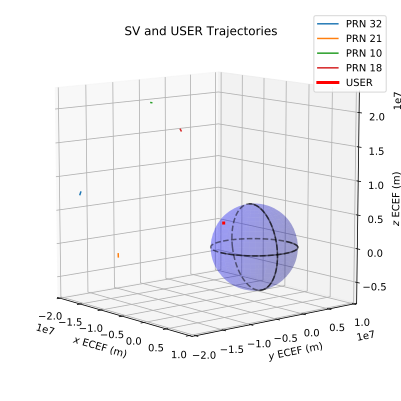

In [22]:
GPS.SV_User_Traj_3D(GPS_ds1,SV_Pos,USER_Pos_ecf,ele=20,azim=-40)
savefig('GPS_ds2.png',dpi=300)

### Simulation for Case #2

In [23]:
Nsamples = SV_Pos.shape[2]
print('Sim Seconds = %d' % Nsamples)
dt = 1
# Save user position history
Pos_KF = zeros((Nsamples,3))
# Save history of error covariance matrix diagonal 
P_diag = zeros((Nsamples,8))

Pseudo_ranges1 = GetPseudoRange(PR_std=0.1,CDt=0,N_SV=4)
GPS_EKF1 = GPS_EKF(USER_xyz_init=USER_Pos_ecf[0,:] + 50*randn(3),
                   dt=1,
                   sigma_xyz=5,
                   Sf=36,
                   Sg=0.01,
                   Rhoerror=36,
                   N_SV=4)
for k in range(Nsamples):
    Pseudo_ranges1.measurement(USER_Pos_ecf[k,:],SV_Pos[:,:,k])
    GPS_EKF1.update(Pseudo_ranges1.USER_PR,SV_Pos[:,:,k])
    Pos_KF[k,:] = GPS_EKF1.x[0:6:2,0]
    P_diag[k,:] = GPS_EKF1.P.diagonal()

Sim Seconds = 132


### The ECEF User Track
The error is small as the noise and other uncertainties, at present are small.

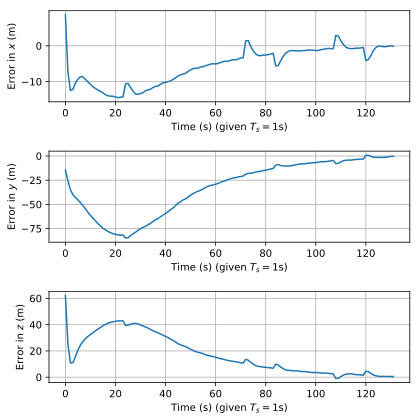

In [24]:
figure(figsize=(6,6))
subplot(311)
Pos_err_KF_ecf = Pos_KF - USER_Pos_ecf
plot(Pos_err_KF_ecf[:,0])
ylabel(r'Error in $x$ (m)')
xlabel(r'Time (s) (given $T_s = 1$s)')
#ylim([-12,12])
grid()
subplot(312)
plot(Pos_err_KF_ecf[:,1])
ylabel(r'Error in $y$ (m)')
xlabel(r'Time (s) (given $T_s = 1$s)')
#ylim([-12,12])
grid()
subplot(313)
plot(Pos_err_KF_ecf[:,2])
ylabel(r'Error in $z$ (m)')
xlabel(r'Time (s) (given $T_s = 1$s)')
#ylim([-12,12])
grid()
tight_layout()

### Selected Error Covariance Results for the Simulation Run
The error covariance matrix, $\mathbf{P}$, is $8\times 8$, with the diagonal entries beingthe variances of each of the states.

Convergence looks reasonable as we see an intial error transient and then a gradual reduction in the covariance.

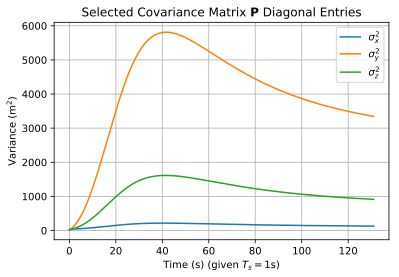

In [25]:
plot(P_diag[:,0])
plot(P_diag[:,2])
plot(P_diag[:,4])
title(r'Selected Covariance Matrix $\mathbf{P}$ Diagonal Entries')
ylabel(r'Variance (m$^2$)')
xlabel(r'Time (s) (given $T_s = 1$s)')
legend((r'$\sigma_x^2$',r'$\sigma_y^2$',r'$\sigma_z^2$'),loc='best')
grid();

* Consider the $6\times 6$ submatrix of $\mathbf{P}$ corresponding to the x, y, and z, position and velocity states, at the final time sample of the simulation run.

In [90]:
print(np.array_str(GPS_EKF1.P[:6,:6], precision=2))
#print np.array_str(x, precision=2, suppress_small=True)

[[ 1.29e+02  2.45e+01  5.32e+02  9.55e+00 -2.75e+02 -5.06e+00]
 [ 2.45e+01  3.48e+01  9.11e+00  8.51e-01 -4.93e+00 -6.00e-01]
 [ 5.32e+02  9.11e+00  3.35e+03  8.30e+01 -1.71e+03 -3.12e+01]
 [ 9.55e+00  8.51e-01  8.30e+01  4.06e+01 -3.18e+01 -3.63e+00]
 [-2.75e+02 -4.93e+00 -1.71e+03 -3.18e+01  9.14e+02  3.50e+01]
 [-5.06e+00 -6.00e-01 -3.12e+01 -3.63e+00  3.50e+01  3.34e+01]]


In [91]:
GPS_EKF1.P.diagonal()

array([1.29140202e+02, 3.47975843e+01, 3.34560907e+03, 4.06004720e+01,
       9.13835319e+02, 3.34143369e+01, 2.90153558e+03, 9.84575907e-01])

### Convert the ECEF User Trajectory Back to ENU Local Coordinates

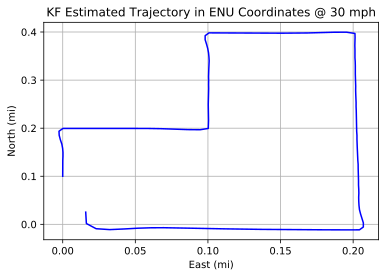

In [26]:
Npts = Pos_KF.shape[0]
Pos_KF_enu = zeros((Npts,3))
for k in range(Npts):
    Pos_KF_enu[k,:] = GPS.ecef2enu(Pos_KF[k,:],
                                   GPS_ds1.ref_ecef,
                                   GPS_ds1.ref_lla[0],
                                   GPS_ds1.ref_lla[1])
plot(Pos_KF_enu[:,0]/1609.344,Pos_KF_enu[:,1]/1609.344,'b')
title(r'KF Estimated Trajectory in ENU \
Coordinates @ %2.0f mph' % (USER_vel,))
xlabel(r'East (mi)')
ylabel(r'North (mi)')
grid();

# References

1. [Phil Kim, *Kalman Filtering for Beginners with MATLAB Examples*, 2011.](https://www.amazon.com/Kalman-Filter-Beginners-MATLAB-Examples/dp/1463648359/ref=sr_1_9?ie=UTF8&qid=1514912616&sr=8-9&keywords=Kalman+Filtering)
2. [Robert Brown and Patrick Hwang, *Introduction to Random Signals and Applied Kalman Filtering*, 4th edition, 2012.](https://www.amazon.com/Introduction-Signals-Applied-Filtering-Exercises/dp/0470609699/ref=sr_1_3?ie=UTF8&qid=1514912616&sr=8-3&keywords=Kalman+Filtering)
3. [Elliot Kaplan, editor, *Understanding GPS Principles and Applications*, 1996 (3rd edition available).](https://www.amazon.com/Understanding-Principles-Applications-Artech-Communications/dp/0890067937/ref=sr_1_2?ie=UTF8&qid=1516027849&sr=8-2&keywords=UNderstanding+GPS)
4. [Dan Simon, *Optimal State Estimation*, 2006.](https://www.amazon.com/Optimal-State-Estimation-Nonlinear-Approaches/dp/0471708585/ref=sr_1_1?s=books&ie=UTF8&qid=1516027927&sr=1-1&keywords=Optimal+State+Estimation)